In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
from importlib import reload
import gdal

sys.path.insert(0, '../src')
import deepgeo.common.filesystem as fs
import deepgeo.common.geofunctions as gf
import deepgeo.common.quality_metrics as qm
import deepgeo.common.visualization as vis
import deepgeo.dataset.image_utils as iutils
import deepgeo.dataset.preprocessor as prep
import deepgeo.dataset.sequential_chips as seqchips
import deepgeo.dataset.utils as dsutils 
import deepgeo.networks.model_builder as mb

reload(dsutils)
reload(gf)
reload(iutils)
reload(mb)
reload(prep)
reload(qm)
reload(seqchips)

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'deepgeo.dataset.sequential_chips' from '../src/deepgeo/dataset/sequential_chips.py'>

## Input Data

In [2]:
# network = 'unet'
fusion = 'late'
file_sufix = '_2018'
DATA_DIR = '/home/raian/doutorado/Dados/generated'
trained_model = os.path.join(DATA_DIR, 'tf_logs', 'experiments', 'unet', 'def_one_cl_rm_nd',
                             'fusion_%s' % fusion,'test_unet_lf_2019_08_01-21_03_15')
# raster_path = os.path.join(DATA_DIR, 'images_5bands', 'stacked_mosaic_2017_2018.tif')
raster_path = os.path.join(DATA_DIR, 'images_5bands', 'stacked_mosaic_2017_2018.tif')
ground_truth = os.path.join(DATA_DIR, 'labels_one_def_cl', 'labels_cloudless_2018.tif')
base_shp = os.path.join(DATA_DIR, 'Prodes_mosaic.shp')

## Output Data

In [3]:
out_pred_dir = os.path.join(trained_model, 'predictions')
output_png = os.path.join(out_pred_dir, 'prediction_png_2018.png')
out_labels_png = os.path.join(out_pred_dir, 'labels_png_2018.png')
output_pred = os.path.join(out_pred_dir, 'prediction_2018.tif')
output_prob = os.path.join(out_pred_dir, 'prediction_2018_prob.tif')
# output_shp = os.path.join(out_pred_dir, 'chip_coords.shp')
fs.mkdir(out_pred_dir)

In [4]:
preproc = prep.Preprocessor(raster_path, no_data=-9999)
preproc.set_nodata_value(-10)
preproc.remove_bands([0, 6])
preproc.standardize_image()
raster_array = preproc.get_raster_stacked_raster()
labels_array = gdal.Open(ground_truth).ReadAsArray()
print(raster_array.shape)
print(labels_array.shape)

params_cg = {'raster_array': raster_array,
             'labels_array': labels_array,
             'overlap': [186, 186],
             'win_size': 286}

chips = seqchips.SequentialChipGenerator(params_cg).generate_chips()

(11534, 13587, 10)
(11534, 13587)


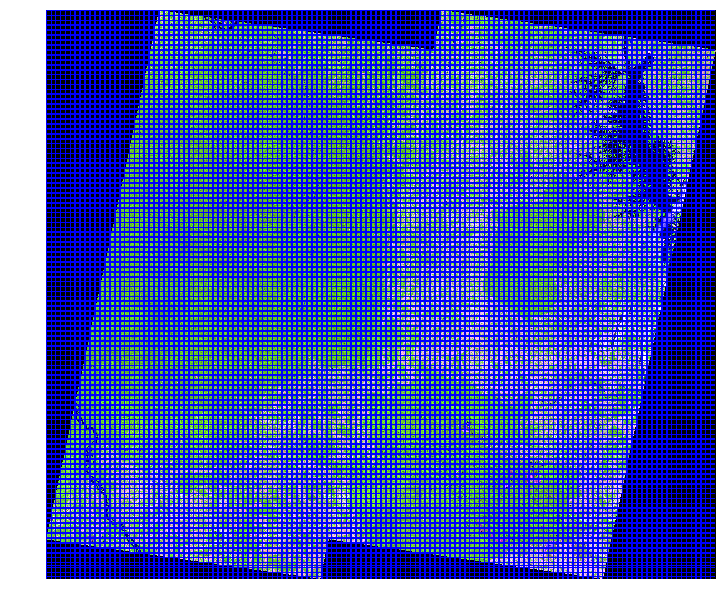

In [5]:
vis.plot_chips(chips, raster_array, bands=[3, 2, 1], contrast=True)

In [6]:
# gf.save_chips_shp(chips, output_shp, raster_path)

In [7]:
# params = {'network': network,
#           'batch_size': 40,
#           'fusion': 'late',
#           'l2_reg_rate': 0.0005,
#           'num_classes': 4}
model = mb.ModelBuilder(trained_model)
chips = model.predict(chips, model_dir=trained_model)

Classifying image with structure  (15776, 286, 286, 10) ...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring paramet

In [8]:
params = {}
params['class_names'] = ['no data', 'not deforestation', 'deforestation', 'clouds']

In [9]:
gf.write_pred_chips(output_pred, raster_path, chips, ref_shp=base_shp)
pred_ds = gdal.Open(output_pred)
pred_rarr = pred_ds.ReadAsArray()
print(pred_rarr.shape)

(11348, 13401)


/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


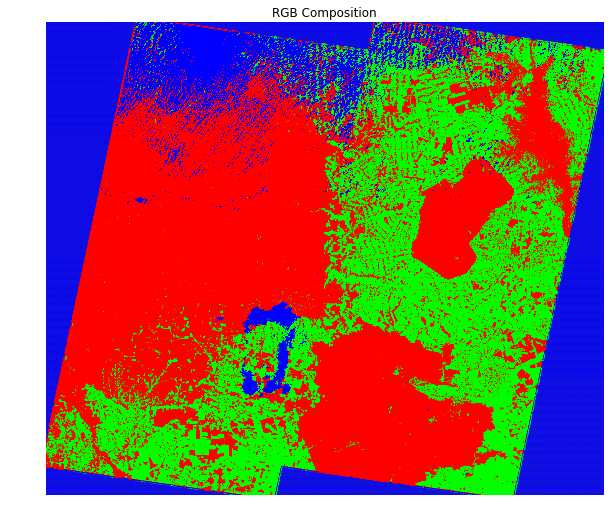

In [10]:
gf.write_pred_chips(output_prob, raster_path, chips, chip_key='probabilities')#, ref_shp=base_shp)
raster_prob = gdal.Open(output_prob)
raster_prob_ar = raster_prob.ReadAsArray()
raster_prob_ar = np.rollaxis(raster_prob_ar, 0, 3)
vis.plot_rgb_img(raster_prob_ar, bands=[1, 2, 3], contrast=False)

In [11]:
pred_ds = gdal.Open(output_pred)
pred_rarr = pred_ds.ReadAsArray()
print(pred_rarr.shape)
print(np.unique(pred_rarr))

(11348, 13401)
[0 1 2 3]


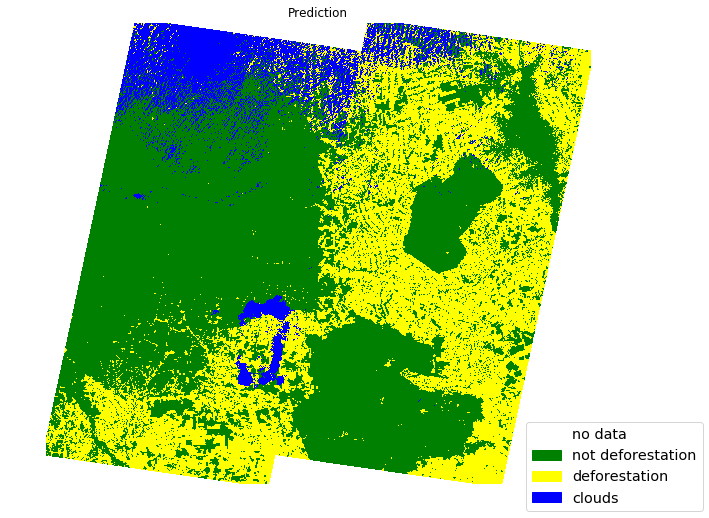

In [12]:
reload(vis)
vis.plot_labels(pred_rarr, params['class_names'], colors=['white', 'green', 'yellow', 'blue'],
                title='Prediction', fig_path=output_png)

In [13]:
true_ds = gdal.Open(ground_truth)
print(ground_truth)
true_rarr = true_ds.ReadAsArray()
print(true_rarr.shape)
print(np.unique(true_rarr))

/home/raian/doutorado/Dados/generated/labels_one_def_cl/labels_cloudless_2018.tif
(11534, 13587)
[0 1 2 3]


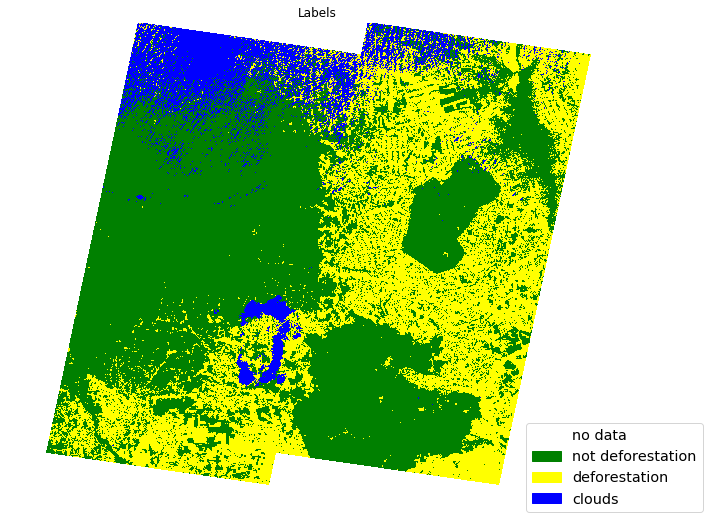

In [14]:
vis.plot_labels(true_rarr, params['class_names'], colors=['white', 'green', 'yellow', 'blue'],
                fig_path=out_labels_png)

UNIQUE Predictions:  [0 1 2 3]
<<------------------------------------------------------------>>
<<---------------- Classification Results -------------------->>
<<------------------------------------------------------------>>
F1-Score:
  - not deforestation: 0.9558182933815998
  - deforestation: 0.9274107784845442
  - clouds: 0.9650247296794685
Precision:
  - not deforestation: 0.9657374343840431
  - deforestation: 0.914659996265288
  - clouds: 0.9537035472715232
Recall:
  - not deforestation: 0.9461008408845354
  - deforestation: 0.9405220902220066
  - clouds: 0.9766179230585286
Accuracy: 0.9469661905828534
AUC-ROC clouds: {'clouds': 0.9990305805853618, 'deforestation': 0.9878791676909984, 'not deforestation': 0.9890683798077132}
AUC-ROC deforestation: {'clouds': 0.9990305805853618, 'deforestation': 0.9878791676909984, 'not deforestation': 0.9890683798077132}
AUC-ROC not deforestation: {'clouds': 0.9990305805853618, 'deforestation': 0.9878791676909984, 'not deforestation': 0.989068379

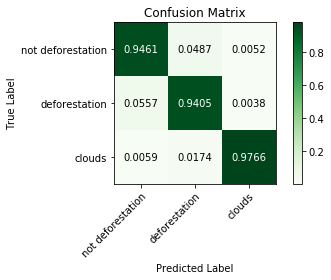

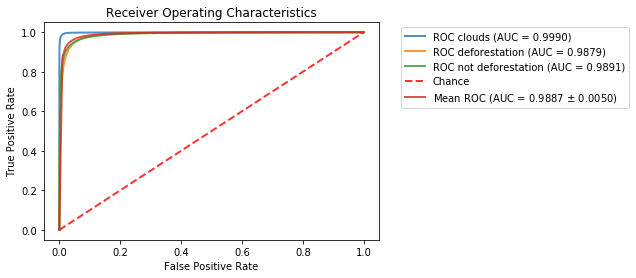

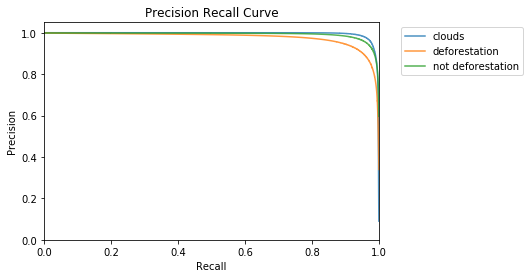

In [15]:
reload(qm)
reload(vis)
qm.evaluate_classification(output_pred, ground_truth, params, output_prob,
                           out_dir=out_pred_dir, file_sufix=file_sufix,
                           classes_ignore=[0])